<a href="https://colab.research.google.com/github/tracyxoxo/INMET-promover-experimentos-de-predic-a-o-de-temperatura/blob/dev/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

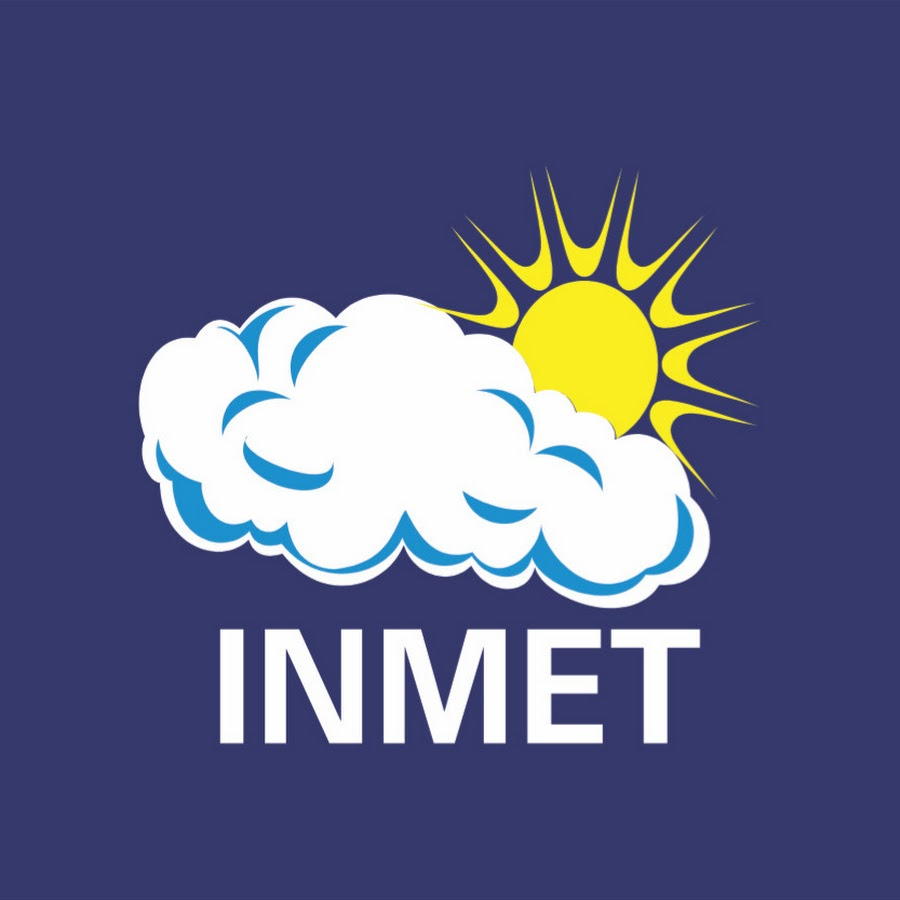
# **Usando dados do Instituto Nacional de Metereologia - INMET, promover experimentos de predição de temperatura**

In [ ]:
import zipfile
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from shutil import move

In [ ]:
files_path = r".\data"
extract_path = r".\data_extracted"
final_path = extract_path+"_final"

os.makedirs(extract_path, exist_ok=True)

for zip_file in os.listdir(files_path):
    if zip_file.endswith(".zip"):

        file = zip_file.removesuffix(".zip")

        extract_to = os.path.join(extract_path, file)
        os.makedirs(extract_to, exist_ok=True)

        with zipfile.ZipFile(os.path.join(files_path, zip_file), 'r') as zip_ref:
            zip_ref.extractall(extract_to)

for dir in os.listdir(extract_path):
    full_name = os.path.join(extract_path, dir)
    if (os.listdir(full_name).count(dir) == 0):
        move(full_name, os.path.join(final_path, dir))

for dir in os.listdir(extract_path):
    full_name = os.path.join(extract_path, dir)
    full_name
    if (os.listdir(full_name).count(dir) > 0):
        os.makedirs(final_path, exist_ok=True)
        move(os.path.join(full_name, dir), final_path)

filterFiles_paths = []

for root, dirs, files in os.walk(final_path):
    for file in files:
        if 'MANAUS' in file: #só usei manaus de exemplo pq é o que eu tinha na minha base aqui
            filterFiles_path = os.path.join(root, file)
            filterFiles_paths.append(filterFiles_path)

filterFiles_paths

['.\\data_extracted_final\\2000\\INMET_N_AM_A101_MANAUS_09-05-2000_A_31-12-2000.CSV',
 '.\\data_extracted_final\\2025\\INMET_N_AM_A101_MANAUS_01-01-2025_A_28-02-2025.CSV']

#### **Processando dados dos diferentes anos disponíveis no website do INMET (2000 - 2025)**

In [ ]:
df_list = []

files = glob.glob(files_path) #Acredito que podemos apenas trocar o files_path por filterFiles_paths aqui não?

for file in files:
    df = pd.read_csv(file, encoding="ISO-8859-1", sep=";", skiprows=8, header=0)
    df_list.append(df)
    general_df = pd.concat(df_list, ignore_index=True)

general_df

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,2025/01/01,0000 UTC,0,"886,1","886,1","885,5",NaN,"20,8","19,5","20,9","20,7","19,5","19,2",92.0,90.0,92.0,8.0,"3,6","1,8",NaN
1,2025/01/01,0100 UTC,0,"886,3","886,4",886,NaN,"20,7","19,3","20,8","20,5","19,5","19,3",93.0,92.0,92.0,4.0,"3,4","1,9",NaN
2,2025/01/01,0200 UTC,0,"886,7","886,7","886,2",NaN,"20,6","19,1","20,8","20,5","19,3",19,92.0,91.0,91.0,3.0,"3,7","1,4",NaN
3,2025/01/01,0300 UTC,0,"886,4","886,7","886,4",NaN,"20,3","18,9","20,6","20,1","19,1","18,7",92.0,91.0,92.0,345.0,3,"1,1",NaN
4,2025/01/01,0400 UTC,0,"885,9","886,4","885,9",NaN,"19,8","18,9","20,3","19,7","19,1","18,8",95.0,92.0,94.0,228.0,2,",3",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798619,2025/02/28,1900 UTC,0,"900,7","901,5","900,7","1612,9","26,9","20,1","30,8","26,9","20,7","18,6",66.0,52.0,66.0,24.0,"5,2","1,8",NaN
798620,2025/02/28,2000 UTC,"6,2","901,3","901,6","900,5","99,1","19,7","18,1","26,9","19,7","20,5",18,91.0,64.0,91.0,297.0,"11,6","4,7",NaN
798621,2025/02/28,2100 UTC,"1,4","901,9","901,9","901,2","70,2","19,9",19,"20,2","19,6",19,"17,9",95.0,90.0,95.0,285.0,"11,6",3,NaN
798622,2025/02/28,2200 UTC,0,"902,5","902,5","901,9","28,4","19,6",19,"19,9","19,6","19,1","18,9",96.0,95.0,96.0,324.0,"4,9","1,6",NaN


In [3]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798624 entries, 0 to 798623
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Data                                                   798624 non-null  object 
 1   Hora UTC                                               798624 non-null  object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       511120 non-null  object 
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  594379 non-null  object 
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        593218 non-null  object 
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       593216 non-null  object 
 6   RADIACAO GLOBAL (Kj/m²)                                385125 non-null  object 
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           590599 non-null  object 
 8   TEMPERATURA DO PONTO DE ORVALHO (°

In [4]:
general_df.drop(['Unnamed: 19'], axis=1, inplace=True)

general_df

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2025/01/01,0000 UTC,0,"886,1","886,1","885,5",NaN,"20,8","19,5","20,9","20,7","19,5","19,2",92.0,90.0,92.0,8.0,"3,6","1,8"
1,2025/01/01,0100 UTC,0,"886,3","886,4",886,NaN,"20,7","19,3","20,8","20,5","19,5","19,3",93.0,92.0,92.0,4.0,"3,4","1,9"
2,2025/01/01,0200 UTC,0,"886,7","886,7","886,2",NaN,"20,6","19,1","20,8","20,5","19,3",19,92.0,91.0,91.0,3.0,"3,7","1,4"
3,2025/01/01,0300 UTC,0,"886,4","886,7","886,4",NaN,"20,3","18,9","20,6","20,1","19,1","18,7",92.0,91.0,92.0,345.0,3,"1,1"
4,2025/01/01,0400 UTC,0,"885,9","886,4","885,9",NaN,"19,8","18,9","20,3","19,7","19,1","18,8",95.0,92.0,94.0,228.0,2,",3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798619,2025/02/28,1900 UTC,0,"900,7","901,5","900,7","1612,9","26,9","20,1","30,8","26,9","20,7","18,6",66.0,52.0,66.0,24.0,"5,2","1,8"
798620,2025/02/28,2000 UTC,"6,2","901,3","901,6","900,5","99,1","19,7","18,1","26,9","19,7","20,5",18,91.0,64.0,91.0,297.0,"11,6","4,7"
798621,2025/02/28,2100 UTC,"1,4","901,9","901,9","901,2","70,2","19,9",19,"20,2","19,6",19,"17,9",95.0,90.0,95.0,285.0,"11,6",3
798622,2025/02/28,2200 UTC,0,"902,5","902,5","901,9","28,4","19,6",19,"19,9","19,6","19,1","18,9",96.0,95.0,96.0,324.0,"4,9","1,6"


In [5]:
#backup_df = general_df


# Data Type conversion

In [6]:
#general_df = backup_df

general_df['Data'] = pd.to_datetime(general_df['Data'])

general_df['Hora UTC'] = general_df['Hora UTC'].str.replace(' UTC', '', regex=False)
general_df['Hora UTC'] = pd.to_datetime(general_df['Hora UTC'], format='%H%M')

general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].str.replace(',', '.')
general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].astype(float)

general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].str.replace(',', '.')
general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = general_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].astype(float)

general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'] = general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'].str.replace(',', '.')
general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'] = general_df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'].astype(float)

general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'].str.replace(',','.')
general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'].astype(float)

general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'].str.replace(',','.')
general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'] = general_df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'].astype(float)

general_df['RADIACAO GLOBAL (Kj/m²)'] = general_df['RADIACAO GLOBAL (Kj/m²)'].str.replace(',','.')
general_df['RADIACAO GLOBAL (Kj/m²)'] = general_df['RADIACAO GLOBAL (Kj/m²)'].astype(float)

general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'] = general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'].str.replace(',','.')
general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'] = general_df['TEMPERATURA DO PONTO DE ORVALHO (°C)'].astype(float)

general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'].str.replace(',','.')
general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'] = general_df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'].astype(float)

general_df['VENTO, RAJADA MAXIMA (m/s)'] = general_df['VENTO, DIREÇÃO HORARIA (gr) (° (gr))'].astype(float)

general_df['VENTO, VELOCIDADE HORARIA (m/s)'] = general_df['VENTO, VELOCIDADE HORARIA (m/s)'].str.replace(',','.')
general_df['VENTO, VELOCIDADE HORARIA (m/s)'] = general_df['VENTO, VELOCIDADE HORARIA (m/s)'].astype(float)

In [8]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798624 entries, 0 to 798623
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   Data                                                   798624 non-null  datetime64[ns]
 1   Hora UTC                                               798624 non-null  datetime64[ns]
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       509838 non-null  float64       
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  594379 non-null  float64       
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        593217 non-null  float64       
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       593216 non-null  float64       
 6   RADIACAO GLOBAL (Kj/m²)                                383929 non-null  float64       
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           5

In [7]:
general_df.describe()

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
count,798624,798624,509838.000000,594379.000000,593217.000000,593216.000000,383929.000000,590599.000000,543411.000000,589310.000000,589306.000000,541577.000000,541301.000000,544942.000000,544409.000000,546089.000000,552796.000000,552796.000000,547421.000000
mean,2025-01-30 00:00:00,1900-01-01 11:29:59.999997184,0.234965,962.398888,962.657356,962.067695,1324.808711,25.219033,20.156382,25.883050,24.581764,20.748858,19.580752,78.566838,72.480883,75.641507,158.499843,158.499843,1.747556
min,2025-01-01 00:00:00,1900-01-01 00:00:00,0.000000,821.500000,821.800000,821.500000,0.000000,7.800000,-10.000000,8.100000,5.700000,-10.000000,-9.900000,7.000000,7.000000,7.000000,1.000000,1.000000,0.000000
25%,2025-01-15 00:00:00,1900-01-01 05:45:00,0.000000,935.500000,935.700000,935.100000,120.600000,22.400000,18.500000,22.800000,22.000000,19.100000,17.900000,68.000000,59.000000,63.000000,72.000000,72.000000,0.600000
50%,2025-01-30 00:00:00,1900-01-01 11:30:00,0.000000,965.800000,966.000000,965.400000,1037.300000,24.700000,20.500000,25.300000,24.200000,21.100000,20.000000,83.000000,75.000000,79.000000,133.000000,133.000000,1.500000
75%,2025-02-14 00:00:00,1900-01-01 17:15:00,0.000000,994.900000,995.200000,994.500000,2342.500000,28.000000,22.200000,29.000000,27.200000,22.700000,21.700000,92.000000,89.000000,91.000000,242.000000,242.000000,2.500000
max,2025-02-28 00:00:00,1900-01-01 23:00:00,87.800000,1045.300000,1046.600000,1042.900000,7188.800000,41.800000,33.100000,43.800000,40.700000,33.000000,30.900000,100.000000,100.000000,100.000000,360.000000,360.000000,17.600000
std,NaN,NaN,1.700493,37.640759,37.674997,37.632590,1227.386462,4.124423,2.833885,4.326903,3.909674,2.791093,2.930506,16.862296,18.795755,17.818153,103.733114,103.733114,1.446258


PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                            Axes(0.125,0.11;0.0383663x0.77)
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)     Axes(0.17104,0.11;0.0383663x0.77)
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          Axes(0.217079,0.11;0.0383663x0.77)
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         Axes(0.263119,0.11;0.0383663x0.77)
RADIACAO GLOBAL (Kj/m²)                                  Axes(0.309158,0.11;0.0383663x0.77)
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             Axes(0.355198,0.11;0.0383663x0.77)
TEMPERATURA DO PONTO DE ORVALHO (°C)                     Axes(0.401238,0.11;0.0383663x0.77)
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               Axes(0.447277,0.11;0.0383663x0.77)
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               Axes(0.493317,0.11;0.0383663x0.77)
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         Axes(0.539356,0.11;0.0383663x0.77)
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         Axes(0.585396,0.11;0.03

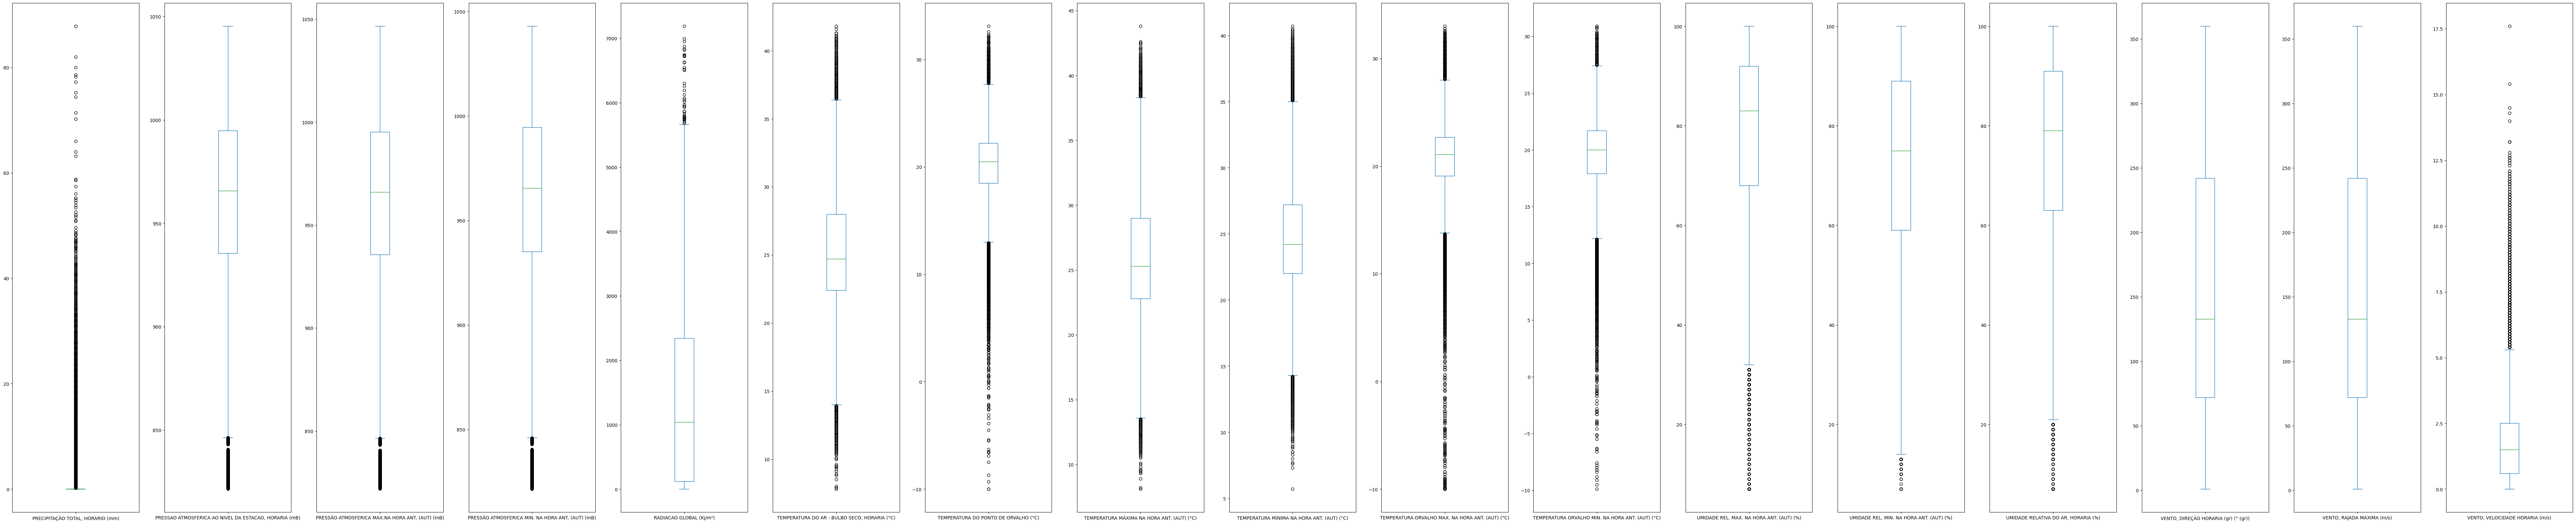

In [9]:
general_df.plot(kind='box',figsize=(100,20), subplots=True)

In [23]:
#plt.rcParams['agg.path.chunksize'] = 200
#plt.rcParams["figure.figsize"] = (50,20)
#plt.plot(general_df['Hora UTC'],general_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'])
#plt.title('Dados de 2025')
##plt.xlabel('Hora')
#plt.ylabel('Temperatura')
#plt.tight_layout()

